In [14]:
!pip install -q opencv-python-headless scikit-image Pillow requests

In [15]:
import requests
from PIL import Image
from io import BytesIO

url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4erboEq4llX4Fb4DqkShIgc3qqt4xm7CaLQ&s"  # contoh
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB')

print("Ukuran asli:", img.size)
img.show()


Ukuran asli: (225, 225)


In [16]:
img.save("fototrial.jpg")

# Downsampling (Average, Median, Max)

In [17]:
import numpy as np
import numpy as np
from PIL import Image

def downsample(img, factor=2, method="average"):
    # Convert PIL image to numpy array
    arr = np.array(img)

    # Get new dimensions
    h, w = arr.shape[:2]
    new_h, new_w = h // factor, w // factor

    # Create empty downsampled image
    down_arr = np.zeros((new_h, new_w, arr.shape[2]), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            # Get block of size (factor x factor)
            block = arr[i*factor:(i+1)*factor, j*factor:(j+1)*factor]

            # Apply method
            if method == "average":
                value = block.mean(axis=(0,1))
            elif method == "median":
                value = np.median(block, axis=(0,1))
            elif method == "max":
                value = block.max(axis=(0,1))
            else:
                raise ValueError("Unknown method")

            down_arr[i, j] = value

    # Convert back to image
    return Image.fromarray(down_arr)




> img, factor=2, method="average"

Here, we can see that we defines the downsampling ration to shrink the image is 2, which halves the size.

> h, w = arr.shape[:2]

> new_h, new_w = h // factor, w // factor

Here, it divides the height and width with the factor

> down_arr = np.zeros((new_h, new_w, arr.shape[2]), dtype=np.uint8)

Here, it creates an empty NumPy array for the smaller image. dtype=np.uint8 ensures pixel values are in the standard 0–255 range.

> for i in range(new_h):

> for j in range(new_w):

> block = arr[i*factor:(i+1)*factor, j*factor:(j+1)*factor]

Here, Loops over each block in the original image. For example, if factor=2, each block is 2×2 pixels.


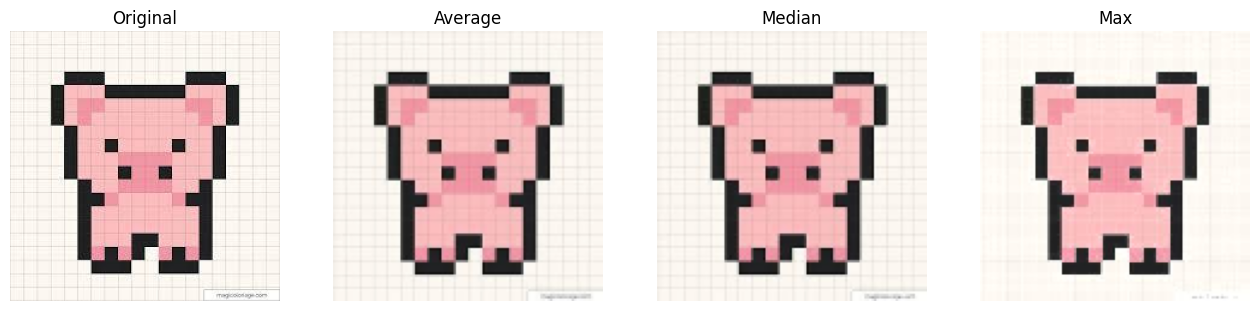

In [18]:
import matplotlib.pyplot as plt

img = Image.open("fototrial.jpg")

down_avg = downsample(img, factor=2, method="average")
down_med = downsample(img, factor=2, method="median")
down_max = downsample(img, factor=2, method="max")

plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Average")
plt.imshow(down_avg)
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Median")
plt.imshow(down_med)
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Max")
plt.imshow(down_max)
plt.axis("off")

plt.show()

**EXPLANATION**
* For downsampling using average, each small block of factor × factor pixels is replaced with the average value of its pixels. The colors are the closest to the original, but smoother. Small differences between pixels will be blended into one (blurred).
* For downsampling using median, it choosing the middle color from a group of pixels instead of the average. Some of the extreme values are ignored. So, the picture comes out sharper.
* For downsamping using maximum values, the photo looks brigther, even sharper than the downsampling using median because it's more constrast and prioritizing choosing the brighter pixel rather than the darker one.

# Upsampling (NN, Bilinear, Bicubic)

In [19]:
import numpy as np
from PIL import Image

def to_array(img):
    arr = np.array(img)
    # Ensure shape (H, W, C)
    if arr.ndim == 2:
        arr = arr[:, :, None]
    return arr

def from_array(arr):
    if arr.shape[2] == 1:
        arr2 = arr[:, :, 0]
        return Image.fromarray(arr2.astype(np.uint8))
    else:
        return Image.fromarray(arr.astype(np.uint8))

# NEAREST NEIGHBOR
def upsample_nearest(img, scale):
    arr = to_array(img)
    h, w, c = arr.shape
    new_h, new_w = int(h * scale), int(w * scale)

    up = arr.repeat(scale, axis=0).repeat(scale, axis=1)
    return from_array(up)

#BILINEAR
def upsample_bilinear(img, scale):
    arr = to_array(img).astype(np.float32)
    h, w, c = arr.shape
    new_h, new_w = int(h * scale), int(w * scale)

    row_idx = (np.arange(new_h) + 0.5) / scale - 0.5
    col_idx = (np.arange(new_w) + 0.5) / scale - 0.5

    row_idx = np.clip(row_idx, 0, h - 1)
    col_idx = np.clip(col_idx, 0, w - 1)

    r0 = np.floor(row_idx).astype(np.int32)
    c0 = np.floor(col_idx).astype(np.int32)
    r1 = np.minimum(r0 + 1, h - 1)
    c1 = np.minimum(c0 + 1, w - 1)

    wr = row_idx - r0
    wc = col_idx - c0

    out = np.zeros((new_h, new_w, c), dtype=np.float32)

    for ch in range(c):
        Ia = arr[r0[:, None], c0[None, :], ch]  # top-left
        Ib = arr[r0[:, None], c1[None, :], ch]  # top-right
        Ic = arr[r1[:, None], c0[None, :], ch]  # bottom-left
        Id = arr[r1[:, None], c1[None, :], ch]  # bottom-right

        w_a = (1 - wr)[:, None] * (1 - wc)[None, :]
        w_b = (1 - wr)[:, None] * wc[None, :]
        w_c = wr[:, None] * (1 - wc)[None, :]
        w_d = wr[:, None] * wc[None, :]

        out[:, :, ch] = Ia * w_a + Ib * w_b + Ic * w_c + Id * w_d

    out = np.clip(out, 0, 255).astype(np.uint8)
    return from_array(out)

#BICUBIC
def upsample_bicubic(img, scale):
    # PIL handles bicubic with Image.BICUBIC
    new_size = (int(img.width * scale), int(img.height * scale))
    return img.resize(new_size, resample=Image.BICUBIC)


For **Nearest Neighbor Method**,
> arr.repeat(scale, axis=0).repeat(scale, axis=1)

This method repeats each pixel value to make the image bigger. If scale=2, each pixel becomes a 2×2 block of the same color.


For Bilinear Method,
For each pixel, we find where it came from in the original image and we take the 4 closest neighbors (top-left, top-right, bottom-left, bottom-right). Then, we compute a weighted average based on distance and closer neighbors get more weight.

Formula:
> (1−wr​)(1−wc​)⋅Ia​+(1−wr​)wc​⋅Ib​+wr​(1−wc​)⋅Ic​+wr​wc​⋅Id​

For Bicubic Method,
it uses 16 surrounding pixels (a 4×4 grid) and cubic interpolation.

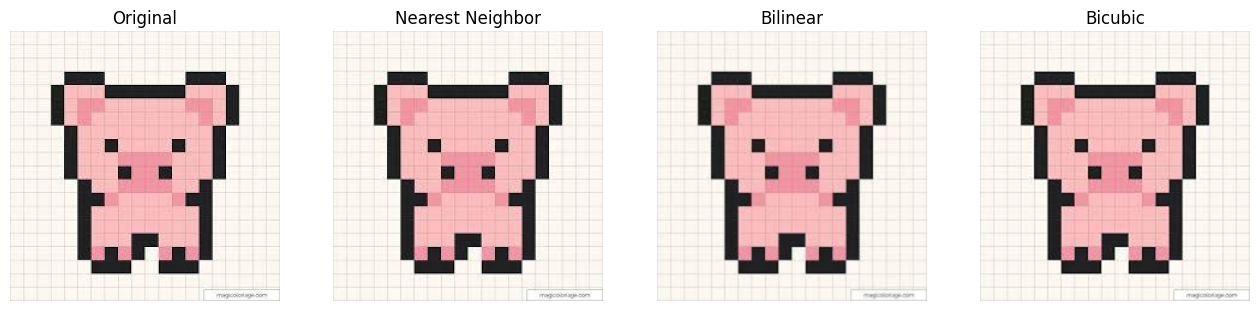

In [20]:
import matplotlib.pyplot as plt

# Load an image
img = Image.open("fototrial.jpg")

# Apply the three upsampling methods
up_nearest = upsample_nearest(img, scale=2)
up_bilinear = upsample_bilinear(img, scale=2)
up_bicubic = upsample_bicubic(img, scale=2)

# Plot results
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Nearest Neighbor")
plt.imshow(up_nearest)
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Bilinear")
plt.imshow(up_bilinear)
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Bicubic")
plt.imshow(up_bicubic)
plt.axis("off")

plt.show()

**EXPLANATION**

* Nearest Neighbor

For each pixel is copied and stretched to fill more space The picture edges are sharper and intend to have no blurring.

* Bilinear

Colors between pixels are averaged. The pig looks smoother, but the edged are less sharper.

* Bicubic

Uses more complex interpolation (16 neighboring pixels). So far, it produces the smoothest result compared to bilinear.